Connected to mcmc (Python 3.10.18)

In [ ]:
from __future__ import annotations
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap, random, lax
import optax
from typing import NamedTuple, Callable, Dict, List, Tuple
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

import os
os.environ['JAX_ENABLE_X64'] = 'True' # Enable float64 for better numerical stability


from kernels.GRAHMC import (
    Array,
    LogProbFn,
    FrictionScheduleFn,
    rahmc_init,
    constant_schedule,
    tanh_schedule,
    sigmoid_schedule,
    linear_schedule,
    sine_schedule,
    standard_normal_log_prob,
    RAHMCState,
    _trajectory_with_schedule,
)

In [ ]:
def compute_autocorr(x: jnp.ndarray, max_lag: int | None = None) -> jnp.ndarray:
    """Compute 1D autocorrelation using FFT."""
    n = x.shape[0]
    if max_lag is None:
        max_lag = n - 1
    x_centered = x - jnp.mean(x)
    # fft_size = 2 ** int(jnp.ceil(jnp.log2(jnp.maximum(1, 2 * n - 1))))
    # fft_x = jnp.fft.fft(x_centered, n=fft_size)
    m = 1
    while m < 2*n - 1:
        m <<= 1
    fft_x = jnp.fft.fft(x_centered, n=m)

    autocorr = jnp.fft.ifft(fft_x * jnp.conj(fft_x)).real[:max_lag]
    return autocorr / autocorr[0]

def estimate_ess_geyer(samples: jnp.ndarray) -> float:
    """Geyer initial positive sequence ESS estimator (JAX compatible)."""
    n = samples.shape[0]
    max_lag = int(jnp.minimum(n // 2, 1000))
    rho = compute_autocorr(samples, max_lag)
    rho_even = rho[1::2]
    rho_odd = rho[2::2]
    n_pairs = jnp.minimum(rho_even.shape[0], rho_odd.shape[0])
    rho_pairs = rho_even[:n_pairs] + rho_odd[:n_pairs]
    positive = rho_pairs > 0
    cutoff = jnp.argmax(~positive)
    cutoff = jnp.where(jnp.any(~positive), cutoff, rho_pairs.shape[0])
    indices = jnp.arange(rho_pairs.shape[0])
    masked_pairs = jnp.where(indices < cutoff, rho_pairs, 0.0)
    rho_sum = rho[0] + 2.0 * jnp.sum(masked_pairs)
    return n / jnp.maximum(rho_sum, 1.0)

def estimate_ess_bulk(samples: jnp.ndarray) -> jnp.ndarray:
    """Bulk ESS across chains and dimensions."""
    n_chains, n_samples, n_dim = samples.shape
    reshaped = samples.reshape(n_chains * n_samples, n_dim)
    dim_indices = jnp.arange(n_dim)
    return vmap(lambda i: estimate_ess_geyer(reshaped[:, i]))(dim_indices)

class TuningParams(NamedTuple):
    """Parameters to optimize (in log space for positivity)."""
    log_step_size: float      # log(eps)
    log_num_steps: float      # log(L)
    log_gamma: float          # log(gamma)
    log_steepness: float      # log(steepness) - for tanh/sigmoid

class DynamicParams(NamedTuple):
    """Parameters to optimize via gradient descent."""
    log_step_size: float
    log_gamma: float
    log_steepness: float


def params_to_dict(params: TuningParams) -> Dict[str, float]:
    """Convert TuningParams to human-readable dict."""
    return {
        'step_size': float(jnp.exp(params.log_step_size)),
        'num_steps': int(jnp.exp(params.log_num_steps)),
        'gamma': float(jnp.exp(params.log_gamma)),
        'steepness': float(jnp.exp(params.log_steepness)),
    }


FRICTION_SCHEDULES = {
    'constant': constant_schedule,
    'tanh': tanh_schedule,
    'sigmoid': sigmoid_schedule,
    'linear': linear_schedule,
    'sine': sine_schedule,
}

def get_friction_schedule(schedule_type: str):
    """Returns SAME function object every time for same type."""
    return FRICTION_SCHEDULES[schedule_type]


# def create_friction_schedule(
#     schedule_type: str,
#     gamma: float,
#     steepness: float = None,
# ):
#     """Create friction schedule from parameters."""
#     if schedule_type == 'constant':
#         return 
#     elif schedule_type == 'tanh':
#         return tanh_friction(gamma, steepness)
#     elif schedule_type == 'sigmoid':
#         return sigmoid_friction(gamma, steepness)
#     elif schedule_type == 'linear':
#         return linear_friction(gamma)
#     elif schedule_type == 'sine':
#         return sine_friction(gamma)
#     else:
#         raise ValueError(f"Unknown schedule type: {schedule_type}")

In [ ]:
@partial(jit, static_argnames=("log_prob_fn", "return_proposal", "friction_schedule", "num_steps"))
def rahmc_step(
    state: RAHMCState,
    step_size: float,
    num_steps: int,
    gamma_max: float,
    steepness: float,
    key: Array,
    log_prob_fn: LogProbFn,
    friction_schedule: FrictionScheduleFn = None,
    return_proposal: bool = False, # return proposal positions and log probs (key, new_state, proposal_position, proposal_log_prob)
) -> Tuple[Array, RAHMCState] | Tuple[Array, RAHMCState, Array, Array]:
    """RAHMC step with optional proposal tracking."""
    if friction_schedule is None:
        friction_schedule = constant_friction(gamma_max)

    n_chains, n_dim = state.position.shape
    pos_dtype = state.position.dtype
    logprob_dtype = state.log_prob.dtype

    key, step_key = random.split(key)
    k_mom, k_acc = random.split(step_key, 2)

    p0 = random.normal(k_mom, shape=(n_chains, n_dim), dtype=pos_dtype)

    kin0 = 0.5 * jnp.sum(p0**2, axis=-1)
    H0 = -state.log_prob + kin0.astype(logprob_dtype)

    total_time = step_size * num_steps

    q, p, lp, glp = _trajectory_with_schedule(
        state.position, p0, step_size, gamma_max, steepness,
        state.log_prob, state.grad_log_prob,
        num_steps, time_offset=0.0, total_time=total_time,
        log_prob_fn=log_prob_fn, friction_schedule=friction_schedule,
    )

    # flip momentum
    p = -p

    # compute final energies
    kin1 = 0.5 * jnp.sum(p**2, axis=-1)
    H1 = -lp + kin1.astype(logprob_dtype)

    # add overflow protection
    H1 = jnp.where(jnp.isfinite(H1), H1, jnp.array(1e10, dtype=logprob_dtype))

    # MH test
    log_alpha = H0 - H1
    delta_H = H1 - H0

    u = random.uniform(k_acc, shape=(n_chains,), dtype=logprob_dtype)
    accept = jnp.log(u) < jnp.minimum(0.0, log_alpha)

    new_pos = jnp.where(accept[:, None], q, state.position)
    new_lp = jnp.where(accept, lp, state.log_prob)
    new_glp = jnp.where(accept[:, None], glp, state.grad_log_prob)
    new_acc = state.accept_count + accept.astype(jnp.int32)

    new_state = RAHMCState(new_pos, new_lp, new_glp, new_acc)
    
    if return_proposal:
        # Return proposal info for ESJD computation
        return key, new_state, q, lp, delta_H
    else:
        return key, new_state
    
    
@partial(jit, static_argnames=("log_prob_fn", "num_samples", "burn_in", "track_proposals", "friction_schedule", "num_steps"))
def rahmc_run(
    key: Array,
    log_prob_fn: LogProbFn,
    init_position: Array,
    step_size: float,
    num_steps: int,
    gamma: float,
    steepness: float,
    num_samples: int,
    burn_in: int = 0,
    friction_schedule: FrictionScheduleFn = None,
    track_proposals: bool = False,
) -> Tuple[Array, Array, Array, RAHMCState] | Tuple[Array, Array, Array, RAHMCState, Array, Array]:
    """
    Run RAHMC with optional proposal tracking.
    
    Args:
        key: PRNG key
        log_prob_fn: Log probability function
        init_position: Initial positions (n_chains, n_dim)
        step_size: Step size epsilon
        num_steps: Number of leapfrog steps
        gamma: Friction parameter
        num_samples: Number of samples to collect
        burn_in: Number of burn-in iterations
        friction_schedule: Friction schedule function
        track_proposals: If True, also track proposal positions and log probs
    
    Returns:
        If track_proposals=False: (samples, log_probs, accept_rate, final_state)
        If track_proposals=True: (samples, log_probs, accept_rate, final_state, 
                                   proposal_positions, proposal_log_probs)
    """
    if friction_schedule is None:
        friction_schedule = constant_friction(gamma)
    state = rahmc_init(init_position, log_prob_fn)
    n_chains, n_dim = state.position.shape

    pos_type = state.position.dtype
    lp_type = state.log_prob.dtype

    eps = jnp.asarray(step_size, dtype=pos_type)
    gam = jnp.asarray(gamma, dtype=pos_type)
    steep = jnp.asarray(steepness, dtype=pos_type)

    # burn-in
    if burn_in > 0:
        def burn_body(carry, _):
            k, s = carry
            k, s = rahmc_step(s, eps, num_steps, gam, steep, k, log_prob_fn, friction_schedule, return_proposal=False)
            return (k, s), None
        (key, state), _ = lax.scan(burn_body, (key, state), length=burn_in)
        state = state._replace(accept_count=jnp.zeros(n_chains, dtype=jnp.int32))

    # sampling
    if track_proposals:
        def body_with_proposals(carry, _):
            k, s = carry
            pre_pos, pre_lp = s.position, s.log_prob
            k, s, prop_pos, prop_lp, delta_H = rahmc_step(
                s, eps, num_steps, gam, steep, k, log_prob_fn, friction_schedule, return_proposal=True
            )
            return (k, s), (pre_pos, pre_lp, prop_pos, prop_lp, delta_H, s.position, s.log_prob)
        
        # (key, state), (samples, lps, prop_positions, prop_lps, delta_H) = lax.scan(
        #     body_with_proposals, (key, state), length=num_samples
        # )
        (key, state), (pre_positions, pre_lps, prop_positions, prop_lps, deltas_H, post_positions, post_lps) = lax.scan(
            body_with_proposals, (key, state), length=num_samples
        )
        
        accept_rate = state.accept_count.astype(jnp.float32) / num_samples

        return (
            post_positions, post_lps,          # samples, lps (post-MH)
            accept_rate, state,                # accept stats + final state
            pre_positions, pre_lps,            # pre-step state (for ESJD)
            prop_positions, prop_lps,          # proposals
            deltas_H                           # ΔH = H1 - H0 per proposal
        )
    else:
        def body(carry, _):
            k, s = carry
            k, s = rahmc_step(s, eps, num_steps, gam, steep, k, log_prob_fn, friction_schedule, return_proposal=False)
            return (k, s), (s.position, s.log_prob)
        
        (key, state), (samples, lps) = lax.scan(body, (key, state), length=num_samples)
        
        accept_rate = state.accept_count.astype(jnp.float32) / num_samples
        return samples, lps, accept_rate, state

In [ ]:
def compute_proposal_esjd_soft(
    initial_positions: jnp.ndarray,
    proposals: jnp.ndarray,
    delta_H: jnp.ndarray, # (n_samples, n_chains)
    # log_prob_initial: jnp.ndarray,
    # log_prob_proposal: jnp.ndarray,
) -> float:
    """
    Compute proposal-level ESJD with soft (probability-weighted) acceptance.
    
    This measures the expected squared jumping distance of proposals,
    weighted by their acceptance probability. This isolates the proposal
    dynamics from the Metropolis-Hastings accept/reject step.
    
    Args:
        initial_positions: (n_samples, n_chains, n_dim) - starting positions
        proposals: (n_samples, n_chains, n_dim) - proposed positions
        log_prob_initial: (n_samples, n_chains) - log prob at initial positions
        log_prob_proposal: (n_samples, n_chains) - log prob at proposals
    
    Returns:
        Mean proposal-level ESJD (scalar)
    """
    # Compute squared jumping distances
    squared_jumps = jnp.sum((proposals - initial_positions)**2, axis=-1)  # (n_samples, n_chains)
    
    # Compute acceptance probabilities (smooth and differentiable!)
    alpha = jnp.minimum(1.0, jnp.exp(-delta_H))  # (n_samples, n_chains)

    # smoother alternative:
    # alpha = jax.nn.sigmoid(-delta_H / 1.0)
    
    # Weight jumps by acceptance probability
    weighted_jumps = squared_jumps * alpha
    
    # Average over all proposals
    esjd = jnp.mean(weighted_jumps)
    
    return esjd



def objective_proposal_esjd(
    # params: TuningParams,
    dyn_params: DynamicParams,
    log_num_steps: float, # static argument
    key: jnp.ndarray,
    log_prob_fn: Callable,
    init_position: jnp.ndarray,
    num_samples: int,
    burn_in: int,
    schedule_type: str,
) -> float:
    """
    Maximize proposal-level ESJD (acceptance-weighted by ΔH) using the pre-step state.
    Returns the NEGATIVE value for minimization.
    """
    # reconstruct full params from dynamic and static parts
    params = TuningParams(
        log_step_size=dyn_params.log_step_size,
        log_num_steps=log_num_steps,
        log_gamma=dyn_params.log_gamma,
        log_steepness=dyn_params.log_steepness
    )

    # Continuous params
    step_size = jnp.exp(params.log_step_size)
    num_steps = int(jnp.maximum(jnp.round(jnp.exp(params.log_num_steps)).astype(jnp.int32), 1))
    gamma     = jnp.exp(params.log_gamma)
    steepness = jnp.exp(params.log_steepness)

    # Friction schedule
    friction_schedule = get_friction_schedule(schedule_type)

    # Run with proposal tracking
    (samples, lps, accept_rate, final_state,
     pre_positions, pre_lps, prop_positions, prop_lps, deltas_H) = rahmc_run(
        key=key,
        log_prob_fn=log_prob_fn,
        init_position=init_position,
        step_size=step_size,
        num_steps=num_steps,                     # JAX int; not static
        gamma=gamma,
        steepness=steepness,
        num_samples=num_samples,
        burn_in=burn_in,
        friction_schedule=friction_schedule,
        track_proposals=True,
    )

    # ESJD over proposals using the pre-step state (q) and proposal (q')
    squared_jumps = jnp.sum((prop_positions - pre_positions) ** 2, axis=-1)  # (S, C)
    alpha = jnp.minimum(1.0, jnp.exp(-deltas_H))                              # exact MH weight
    # If gradients are twitchy, try: alpha = jax.nn.sigmoid(-deltas_H / 1.0)
    esjd = jnp.mean(squared_jumps * alpha)

    log_esjd = jnp.log(esjd + 1e-10)

    # Differentiable acceptance guard (from α above)
    mean_alpha = jnp.mean(alpha)
    target_accept = 0.65
    accept_penalty    = (mean_alpha - target_accept) ** 2
    low_accept_guard  = jnp.maximum(0.0, 0.15 - mean_alpha) ** 2
    high_accept_guard = jnp.maximum(0.0, mean_alpha - 0.90) ** 2

    objective_value = log_esjd \
        - 50.0 * accept_penalty \
        - 25.0 * (low_accept_guard + high_accept_guard)

    # Soft parameter constraints
    penalty = 0.0
    penalty += 1.0 * jnp.maximum(0.0, params.log_step_size - jnp.log(1.0)) ** 2
    penalty += 1.0 * jnp.maximum(0.0, -params.log_step_size - jnp.log(0.01)) ** 2

    penalty += 5.0 * jnp.maximum(0.0, jnp.log(10.0) - params.log_num_steps) ** 2
    penalty += 1.0 * jnp.maximum(0.0, params.log_num_steps - jnp.log(100.0)) ** 2
    
    penalty += 100.0 * jnp.maximum(0.0, params.log_gamma - jnp.log(1.5)) ** 2
    penalty += 1.0 * jnp.maximum(0.0, jnp.log(0.01) - params.log_gamma) ** 2

    penalty += 0.5 * jnp.maximum(0.0, params.log_steepness - jnp.log(50.0)) ** 2
    penalty += 0.5 * jnp.maximum(0.0, jnp.log(0.5) - params.log_steepness) ** 2

    return -(objective_value - penalty)




def objective_proposal_esjd_variance_reduced(
    #params: TuningParams,
    dyn_params: DynamicParams,
    log_num_steps: float, # static argument
    keys: jnp.ndarray,
    log_prob_fn: Callable,
    init_position: jnp.ndarray,
    num_samples: int,
    burn_in: int,
    schedule_type: str,
) -> float:
    """Proposal-level ESJD objective with multiple runs for variance reduction."""
    
    def single_run(key):
        return objective_proposal_esjd(
            dyn_params, log_num_steps,
            key, log_prob_fn, init_position,
            num_samples, burn_in, schedule_type
        )
    
    # Average over multiple runs
    neg_esjd_values = vmap(single_run)(keys)
    return jnp.mean(neg_esjd_values)

In [ ]:
def optimize_parameters(
    key: jnp.ndarray,
    log_prob_fn: Callable,
    init_position: jnp.ndarray,
    schedule_type: str,
    initial_dyn_params: DynamicParams, # <-- New: Pass in initial guess for ε, γ
    log_num_steps: float,               # <-- New: Pass in the fixed L
    num_samples: int = 1000,
    burn_in: int = 500,
    n_optimization_steps: int = 50,
    n_runs_per_eval: int = 3,
    learning_rate: float = 0.02,
    verbose: bool = False, # <-- Changed default to False
    objective_type: str = 'proposal_esjd',
) -> Tuple[DynamicParams, List[Dict], float]: # <-- New: Return (params, history, score)
    """
    Optimize DYNAMIC RAHMC parameters (step_size, gamma, steepness)
    for a FIXED trajectory length (log_num_steps).
    """
    
    # Use the static L and initial dynamic params passed in
    dyn_params = initial_dyn_params
    current_log_num_steps = log_num_steps # This is now a fixed, static arg
    
    # Choose objective function
    if objective_type == 'proposal_esjd':
        # Use the robust log-ESJD objective from our last attempt
        objective_fn = objective_proposal_esjd_variance_reduced
        metric_name = "log(ESJD)"
    else:
        raise ValueError(f"Unknown objective_type: {objective_type}")
    
    # Create optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(dyn_params)
    
    # Create gradient function
    grad_fn = jax.grad(objective_fn, argnums=0)
    
    # Track history
    history = []
    best_neg_metric = jnp.inf
    best_dyn_params = dyn_params
    
    # This (optional) print is for the *start* of the inner loop
    if verbose:
        print("\n" + "="*80)
        print(f"OPTIMIZING: {schedule_type.upper()} | FIXED L={int(jnp.exp(log_num_steps))}")
        print("="*80)
    
    for iteration in range(n_optimization_steps):
        # Generate keys for this iteration
        key, *eval_keys = random.split(key, n_runs_per_eval + 1)
        eval_keys = jnp.array(eval_keys)
        
        # Evaluate objective
        neg_metric = objective_fn(
            dyn_params, current_log_num_steps, # Pass separately
            eval_keys, log_prob_fn, init_position,
            num_samples, burn_in, schedule_type
        )
        
        # Compute gradient
        grads = grad_fn(
            dyn_params, current_log_num_steps, # Pass separately
            eval_keys, log_prob_fn, init_position,
            num_samples, burn_in, schedule_type
        )
        
        # Update parameters
        updates, opt_state = optimizer.update(grads, opt_state)
        dyn_params = optax.apply_updates(dyn_params, updates)
        
        # Track best
        if neg_metric < best_neg_metric:
            best_neg_metric = neg_metric
            best_dyn_params = dyn_params
        
        # Rebuild full params for logging
        full_params = TuningParams(
            dyn_params.log_step_size,
            current_log_num_steps,
            dyn_params.log_gamma,
            dyn_params.log_steepness
        )
        params_dict = params_to_dict(full_params)
        history.append({
            'iteration': iteration,
            f'neg_{metric_name.lower()}': float(neg_metric),
            metric_name.lower(): float(-neg_metric),
            **params_dict,
        })
        
        # Print progress (if enabled)
        if verbose and (iteration % 25 == 0 or iteration == n_optimization_steps - 1):
            print(f"  Iter {iteration:3d}: {metric_name}={-float(neg_metric):7.3f} | "
                  f"ε={params_dict['step_size']:.4f}, "
                  f"γ={params_dict['gamma']:.4f}, "
                  f"steep={params_dict['steepness']:.2f}")

    # --- CRITICAL ---
    # The entire "Discrete refinement" loop is GONE.
    # We also remove the final "OPTIMIZATION COMPLETE" print block.
    # We return the best dynamic params and the final score.
    
    return best_dyn_params, history, best_neg_metric

In [ ]:
def optimize_all_schedules(
    key: jnp.ndarray,
    log_prob_fn: Callable,
    init_position: jnp.ndarray,
    schedule_types: List[str] = None,
    objective_type: str = 'proposal_esjd',
    L_grid: List[int] = None, # <-- New
    # Other optimization params will be passed down
    n_optimization_steps: int = 50,
    num_samples: int = 1000,
    burn_in: int = 500,
    n_runs_per_eval: int = 3,
    learning_rate: float = 0.02,
    verbose: bool = True, # This controls *this* function's printing
) -> Dict[str, Tuple[TuningParams, List[Dict]]]:
    """
    Find the best (L, ε, γ, steepness) by grid-searching L
    and running GD for (ε, γ, steepness) at each L.
    """
    
    if schedule_types is None:
        schedule_types = ['constant', 'tanh', 'sigmoid', 'linear', 'sine']
    if L_grid is None:
        L_grid = [15, 30, 45, 60, 75] # A sensible default
    
    results = {}
    
    for schedule_type in schedule_types:
        if verbose:
            print("\n" + "="*80)
            print(f"OPTIMIZING: {schedule_type.upper()}")
            print(f"L_grid: {L_grid}")
            print("="*80)
        
        # Track the best result across all L's
        best_overall_neg_metric = jnp.inf
        best_overall_params = None
        best_overall_history = None

        # Define a *consistent* starting point for the GD for each L
        initial_dyn_params = DynamicParams(
            log_step_size=jnp.log(0.15),
            log_gamma=jnp.log(0.5),
            log_steepness=jnp.log(5.0),
        )

        for L in L_grid:
            key, subkey = random.split(key)
            log_L_static = jnp.log(float(L))
            
            if verbose:
                print(f"\n--- Optimizing for L = {L} ---")

            # Call our new "worker" function
            tuned_dyn_params, history, final_neg_metric = optimize_parameters(
                key=subkey,
                log_prob_fn=log_prob_fn,
                init_position=init_position,
                schedule_type=schedule_type,
                initial_dyn_params=initial_dyn_params, # Pass in guess
                log_num_steps=log_L_static,           # Pass in fixed L
                # Pass down the optimization settings
                num_samples=num_samples,
                burn_in=burn_in,
                n_optimization_steps=n_optimization_steps,
                n_runs_per_eval=n_runs_per_eval,
                learning_rate=learning_rate,
                verbose=False, # <-- CRITICAL: Keep inner loop quiet
                objective_type=objective_type
            )
            
            if verbose:
                print(f"--- L = {L} complete. Final Score: {-final_neg_metric:.4f} ---")

            # Check if this L was the best one so far for this schedule
            if final_neg_metric < best_overall_neg_metric:
                best_overall_neg_metric = final_neg_metric
                best_overall_history = history
                # Reconstruct the *full* TuningParams
                best_overall_params = TuningParams(
                    log_step_size=tuned_dyn_params.log_step_size,
                    log_num_steps=log_L_static,
                    log_gamma=tuned_dyn_params.log_gamma,
                    log_steepness=tuned_dyn_params.log_steepness
                )
        
        # Store the best (L, ε, γ, steepness) combo for this schedule_type
        results[schedule_type] = (best_overall_params, best_overall_history)
        
        # Print the final best result for this schedule
        if verbose:
            print("\n" + "-"*80)
            print(f"OPTIMIZATION COMPLETE FOR: {schedule_type.upper()}")
            print("-"*80)
            best_dict = params_to_dict(best_overall_params)
            print(f"Best Metric: {-float(best_overall_neg_metric):.3f}")
            print(f"Optimal parameters found:")
            print(f"  L (num_steps) = {best_dict['num_steps']}")
            print(f"  ε (step_size) = {best_dict['step_size']:.4f}")
            print(f"  γ (gamma)     = {best_dict['gamma']:.4f}")
            print(f"  steepness     = {best_dict['steepness']:.2f}")
            print("="*80 + "\n")

    return results

In [ ]:
def evaluate_sampling_performance(
    key: jnp.ndarray,
    log_prob_fn: Callable,
    init_position: jnp.ndarray,
    results: Dict[str, Tuple[TuningParams, List[Dict]]],
    num_samples: int = 5000,
    burn_in: int = 1000,
) -> Dict[str, Dict]:
    """
    Evaluate and compare sampling performance across all schedules.

    Expects rahmc_run(..., track_proposals=True) to return the 9-tuple:
      (samples, lps, accept_rate, final_state,
       pre_positions, pre_lps, prop_positions, prop_lps, deltas_H)
    where:
      - samples/lps: post-MH states/logps per iteration
      - pre_positions/pre_lps: pre-step states used to form proposals
      - prop_positions/prop_lps: proposals (before MH)
      - deltas_H: H1 − H0 for each proposal (per step, per chain)
    """

    performance = {}

    print("\n" + "=" * 80)
    print("EVALUATING SAMPLING PERFORMANCE")
    print("=" * 80)

    for schedule_type, (params, _) in results.items():
        key, subkey = random.split(key)

        # Unpack tuned params (your helper)
        params_dict = params_to_dict(params)
        step_size = params_dict["step_size"]
        num_steps = int(params_dict["num_steps"])  # Python int is fine for evaluation
        gamma = params_dict["gamma"]
        steepness = params_dict["steepness"]

        friction_schedule = get_friction_schedule(schedule_type)

        # Run sampling with proposal tracking
        import time
        start = time.time()
        results_tuple = rahmc_run(
            key=subkey,
            log_prob_fn=log_prob_fn,
            init_position=init_position,
            step_size=step_size,
            num_steps=num_steps,
            gamma=gamma,
            steepness=steepness,
            num_samples=num_samples,
            burn_in=burn_in,
            friction_schedule=friction_schedule,
            track_proposals=True,
        )
        elapsed = time.time() - start

        # Unpack the 9-tuple (see docstring)
        (samples, lps, accept_rate, final_state,
         pre_positions, pre_lps, prop_positions, prop_lps, deltas_H) = results_tuple

        # ---------- ESS diagnostics ----------
        # samples: (num_samples, n_chains, n_dim)
        samples_transposed = jnp.transpose(samples, (1, 0, 2))  # (n_chains, num_samples, n_dim)
        ess_per_dim = estimate_ess_bulk(samples_transposed)     # user-provided
        mean_ess = float(jnp.mean(ess_per_dim))
        min_ess = float(jnp.min(ess_per_dim))

        # ---------- Proposal-level ESJD (acceptance-weighted by ΔH) ----------
        # ESJD over proposals uses pre-step positions
        # squared jump per step/chain
        squared_jumps = jnp.sum((prop_positions - pre_positions) ** 2, axis=-1)  # (S, C)
        alpha = jnp.minimum(1.0, jnp.exp(-deltas_H))                              # exact MH weight
        proposal_esjd = float(jnp.mean(squared_jumps * alpha))
        # (If you prefer your helper:)
        # proposal_esjd = float(compute_proposal_esjd_soft(pre_positions, prop_positions, deltas_H))

        # ---------- Accepted ESJD (realized) ----------
        diffs = samples[1:] - samples[:-1]                          # (S-1, C, D)
        accepted_esjd = float(jnp.mean(jnp.sum(diffs ** 2, axis=-1)))

        ess_per_second = mean_ess / max(elapsed, 1e-9)
        mean_accept = float(jnp.mean(accept_rate))

        performance[schedule_type] = {
            "mean_ess": mean_ess,
            "min_ess": min_ess,
            "proposal_esjd": proposal_esjd,
            "accepted_esjd": accepted_esjd,
            "ess_per_second": ess_per_second,
            "accept_rate": mean_accept,
            "time": elapsed,
            "samples": samples,
            "log_probs": lps,
            "params": params_dict,
        }

        print(f"\n{schedule_type.upper():12s} | "
              f"ESS: {mean_ess:7.1f} | "
              f"Prop-ESJD: {proposal_esjd:8.3f} | "
              f"Acc-ESJD: {accepted_esjd:8.3f} | "
              f"Accept: {mean_accept:.3f} | "
              f"Time: {elapsed:6.2f}s")

    print("=" * 80 + "\n")
    return performance

In [ ]:
def plot_performance_summary(performance: Dict[str, Dict]):
    """Bar plots comparing key performance metrics."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    
    schedules = list(performance.keys())
    colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12', '#9b59b6']
    
    # ESS comparison
    mean_ess = [performance[s].get('mean_ess', float('nan')) for s in schedules]
    axes[0].bar(schedules, mean_ess, color=colors[:len(schedules)], alpha=0.7, edgecolor='black')
    axes[0].set_ylabel('Mean ESS', fontsize=12)
    axes[0].set_title('Effective Sample Size', fontsize=13, fontweight='bold')
    axes[0].grid(axis='y', alpha=0.3)
    
    # Proposal ESJD
    prop_esjd = [performance[s].get('proposal_esjd', float('nan')) for s in schedules]
    acc_esjd = [performance[s].get('accepted_esjd', float('nan')) for s in schedules]
    x = np.arange(len(schedules))
    width = 0.35
    axes[1].bar(x - width/2, prop_esjd, width, label='Proposal',
                   color=colors[:len(schedules)], alpha=0.7, edgecolor='black')
    axes[1].bar(x + width/2, acc_esjd, width, label='Trajectory',
                   color='#95a5a6', alpha=0.6, edgecolor='black')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(schedules)
    axes[1].set_ylabel('ESJD', fontsize=12)
    axes[1].set_title('ESJD (proposal vs accepted)', fontsize=13, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].grid(axis='y', alpha=0.3)
    
    # Acceptance rate
    accept_rates = [performance[s].get('accept_rate', float('nan')) for s in schedules]
    axes[2].bar(schedules, accept_rates, color=colors[:len(schedules)], alpha=0.7, edgecolor='black')
    axes[2].set_ylabel('Acceptance Rate', fontsize=12)
    axes[2].set_title('Metropolis Acceptance', fontsize=13, fontweight='bold')
    axes[2].axhline(0.651, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Optimal (HMC)')
    axes[2].legend(fontsize=9)
    axes[2].grid(axis='y', alpha=0.3)
    axes[2].set_ylim([0, 1])
    
    # ESS per second
    ess_per_sec = [performance[s].get('ess_per_second', float('nan')) for s in schedules]
    axes[3].bar(schedules, ess_per_sec, color=colors[:len(schedules)], alpha=0.7, edgecolor='black')
    axes[3].set_ylabel('ESS per Second', fontsize=12)
    axes[3].set_title('Sampling Efficiency', fontsize=13, fontweight='bold')
    axes[3].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('performance_summary.png', dpi=150, bbox_inches='tight')
    print("✓ Saved performance summary to 'performance_summary.png'")
    plt.show()

In [ ]:
def plot_friction_schedules(results: Dict[str, Tuple[TuningParams, List[Dict]]]):
    """Visualize the optimized friction schedules."""
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = {
        'constant': '#e74c3c',
        'tanh': '#3498db',
        'sigmoid': '#2ecc71',
        'linear': '#f39c12',
        'sine': '#9b59b6',
    }
    
    t_vals = jnp.linspace(0, 1, 200)
    
    for schedule_type, (params, _) in results.items():
        params_dict = params_to_dict(params)
        gamma = params_dict['gamma']
        steepness = params_dict['steepness']
        
        friction_fn = get_friction_schedule(schedule_type)
        gamma_vals = vmap(lambda t: friction_fn(t, 1.0, gamma, steepness))(t_vals)
        
        ax.plot(t_vals, gamma_vals, 
               label=f"{schedule_type} (γ={gamma:.3f})",
               color=colors.get(schedule_type, 'gray'),
               linewidth=2.5, alpha=0.8)
    
    ax.axhline(0, color='black', linestyle='--', alpha=0.3, linewidth=1)
    ax.set_xlabel('Normalized Time (t/T)', fontsize=12)
    ax.set_ylabel('Friction γ(t)', fontsize=12)
    ax.set_title('Optimized Friction Schedules', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('friction_schedules.png', dpi=150, bbox_inches='tight')
    print("✓ Saved friction schedules to 'friction_schedules.png'")
    plt.show()



def plot_sampling_comparison(performance: Dict[str, Dict], dim: int = 0):
    """Plot trace plots and marginals for comparison."""
    
    n_schedules = len(performance)
    fig, axes = plt.subplots(n_schedules, 2, figsize=(14, 3*n_schedules))
    
    if n_schedules == 1:
        axes = axes[None, :]
    
    colors = {
        'constant': '#e74c3c',
        'tanh': '#3498db',
        'sigmoid': '#2ecc71',
        'linear': '#f39c12',
        'sine': '#9b59b6',
    }
    
    for idx, (schedule_type, perf) in enumerate(performance.items()):
        prop_esjd = perf.get('proposal_esjd', float('nan'))
        samples = perf['samples']
        color = colors.get(schedule_type, 'gray')
        
        # Trace plot (first chain, specified dimension)
        ax_trace = axes[idx, 0]
        trace = samples[:, 0, dim]  # (n_samples,)
        ax_trace.plot(trace, color=color, alpha=0.7, linewidth=0.5)
        ax_trace.set_ylabel(f'{schedule_type}\nDim {dim}', fontsize=11)
        ax_trace.set_xlabel('Sample', fontsize=10)
        ax_trace.grid(True, alpha=0.3)
        ax_trace.set_title(f"Trace Plot | ESS={perf['mean_ess']:.0f}, ESJD={prop_esjd:.3f}", fontsize=11)
        
        # Marginal histogram
        ax_hist = axes[idx, 1]
        all_samples = samples[:, :, dim].flatten()  # all chains
        ax_hist.hist(all_samples, bins=50, color=color, alpha=0.6, 
                     density=True, edgecolor='black', linewidth=0.5)
        
        # Overlay true density (for Gaussian)
        x_range = jnp.linspace(-4, 4, 200)
        true_density = jnp.exp(-0.5 * x_range**2) / jnp.sqrt(2 * jnp.pi)
        ax_hist.plot(x_range, true_density, 'k--', linewidth=2, label='True')
        
        ax_hist.set_ylabel('Density', fontsize=10)
        ax_hist.set_xlabel(f'Dimension {dim}', fontsize=10)
        ax_hist.set_title(f"Marginal | Accept={perf['accept_rate']:.3f}", fontsize=11)
        ax_hist.legend(fontsize=9)
        ax_hist.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('sampling_comparison.png', dpi=150, bbox_inches='tight')
    print("✓ Saved sampling comparison to 'sampling_comparison.png'")
    plt.show()


def plot_optimization_history(results: Dict[str, Tuple[TuningParams, List[Dict]]]):
    """Plot optimization history for all schedules."""
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()
    
    # Colors for each schedule
    colors = {
        'constant': '#e74c3c',
        'tanh': '#3498db',
        'sigmoid': '#2ecc71',
        'linear': '#f39c12',
        'sine': '#9b59b6',
    }
    
    metric_key = "ess"
    metric_title = "ESS"
    for _, history in results.items():
        if history:
            entry = history[-1]
            if "esjd" in entry:
                metric_key, metric_title = "esjd", "ESJD"
            elif "mixing" in entry:
                metric_key, metric_title = "mixing", "Mixing"
            elif "ess" in entry:
                metric_key, metric_title = "ess", "ESS"
            break
    metrics = [metric_key, "step_size", "num_steps", "gamma", "steepness"]
    titles = [metric_title, "Step Size (ε)", "Num Steps (L)", "Gamma (γ)", "Steepness"]
    
    for idx, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[idx]
        
        for schedule_type, (_, history) in results.items():
            iterations = [h['iteration'] for h in history]
            values = [h.get(metric, float("nan")) for h in history]
            
            ax.plot(iterations, values, 
                   label=schedule_type, 
                   color=colors.get(schedule_type, 'gray'),
                   linewidth=2, alpha=0.8)
        
        ax.set_xlabel('Iteration', fontsize=11)
        ax.set_ylabel(title, fontsize=11)
        ax.set_title(title, fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=9)
    
    # Remove extra subplot
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.savefig('optimization_history.png', dpi=150, bbox_inches='tight')
    print("\n✓ Saved optimization history to 'optimization_history.png'")
    plt.show()

In [ ]:
def run_complete_analysis(
    dim: int = 10,
    n_optimization_steps: int = 50, # This is now steps *per L*
    n_eval_samples: int = 5000,
    seed: int = 42,
):
    """
    Complete analysis pipeline:
    1. Optimize parameters for all friction schedules
    2. Compare optimized friction functions
    3. Evaluate sampling performance
    4. Visualize results
    """
    
    print("\n" + "="*80)
    print(f"COMPLETE RAHMC ANALYSIS: {dim}-DIMENSIONAL GAUSSIAN")
    print("="*80)
    
    # Setup
    key = random.PRNGKey(seed)
    key, init_key = random.split(key)
    
    # Target: Standard normal
    log_prob_fn = standard_normal_log_prob
    init_position = random.normal(init_key, shape=(4, dim))  # 4 chains
    
    # 1. Optimize all schedules
    print("\n" + "─"*80)
    print("STEP 1: OPTIMIZING PARAMETERS")
    print("─"*80)
    
    key, opt_key = random.split(key)
    
    # --- START MODIFICATION ---
    # We now pass the L_grid and optimization steps here
    results = optimize_all_schedules(
        key=opt_key,
        log_prob_fn=log_prob_fn,
        init_position=init_position,
        schedule_types=['constant', 'tanh', 'sigmoid', 'linear', 'sine'],
        L_grid=[30, 40, 50, 60, 70, 80],
        num_samples=1000,
        burn_in=500,
        n_optimization_steps=n_optimization_steps, # Pass down
        n_runs_per_eval=3,
        learning_rate=0.015,
        verbose=True, # This controls the new "manager" printing
    )
    # --- END MODIFICATION ---

    # 2. Plot optimization history
    print("\n" + "─"*80)
    print("STEP 2: PLOTTING OPTIMIZATION HISTORY")
    print("─"*80)
    # Note: This plot will now only show the history for the *winning L*
    plot_optimization_history(results)
    
    # ... (rest of the function is unchanged) ...
    
    plot_friction_schedules(results)
    
    print("\n" + "─"*80)
    print("STEP 4: EVALUATING SAMPLING PERFORMANCE")
    print("─"*80)
    
    key, eval_key = random.split(key)
    performance = evaluate_sampling_performance(
        key=eval_key,
        log_prob_fn=log_prob_fn,
        init_position=init_position,
        results=results,
        num_samples=n_eval_samples,
        burn_in=1000,
    )
    
    print("\n" + "─"*80)
    print("STEP 5: PLOTTING SAMPLING COMPARISONS")
    print("─"*80)
    plot_sampling_comparison(performance, dim=0)
    plot_performance_summary(performance)
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE!")
    print("="*80)
    
    return results, performance


COMPLETE RAHMC ANALYSIS: 10-DIMENSIONAL GAUSSIAN

────────────────────────────────────────────────────────────────────────────────
STEP 1: OPTIMIZING PARAMETERS
────────────────────────────────────────────────────────────────────────────────

OPTIMIZING: CONSTANT
L_grid: [30, 40, 50, 60, 70, 80]

--- Optimizing for L = 30 ---


/Users/chuxuanai/miniconda3/envs/mcmc/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:122: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)


--- L = 30 complete. Final Score: -33.0599 ---

--- Optimizing for L = 40 ---
--- L = 40 complete. Final Score: -36.1246 ---

--- Optimizing for L = 50 ---
--- L = 50 complete. Final Score: -36.2176 ---

--- Optimizing for L = 60 ---
--- L = 60 complete. Final Score: -37.4860 ---

--- Optimizing for L = 70 ---
--- L = 70 complete. Final Score: -34.5849 ---

--- Optimizing for L = 80 ---
--- L = 80 complete. Final Score: -35.8775 ---

--------------------------------------------------------------------------------
OPTIMIZATION COMPLETE FOR: CONSTANT
--------------------------------------------------------------------------------
Best Metric: -33.060
Optimal parameters found:
  L (num_steps) = 30
  ε (step_size) = 0.3332
  γ (gamma)     = 1.6566
  steepness     = 5.00


OPTIMIZING: TANH
L_grid: [30, 40, 50, 60, 70, 80]

--- Optimizing for L = 30 ---
--- L = 30 complete. Final Score: -38.2192 ---

--- Optimizing for L = 40 ---
--- L = 40 complete. Final Score: -41.8734 ---

--- Optimizing

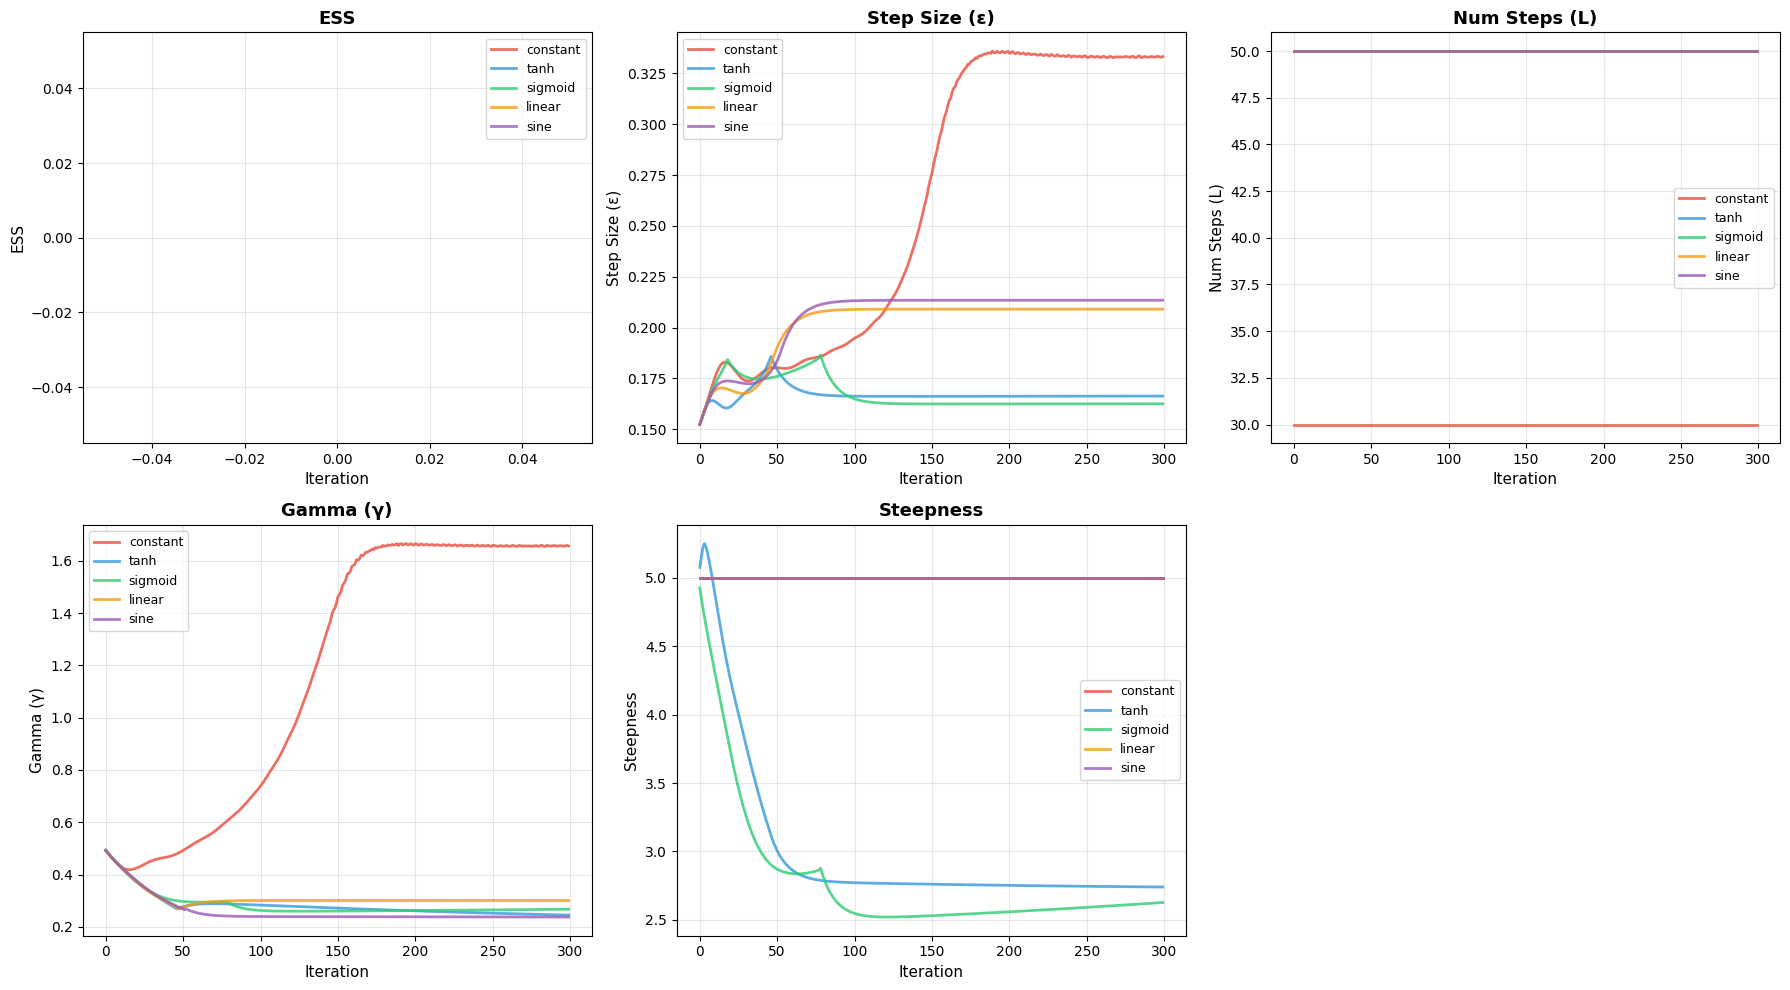

✓ Saved friction schedules to 'friction_schedules.png'


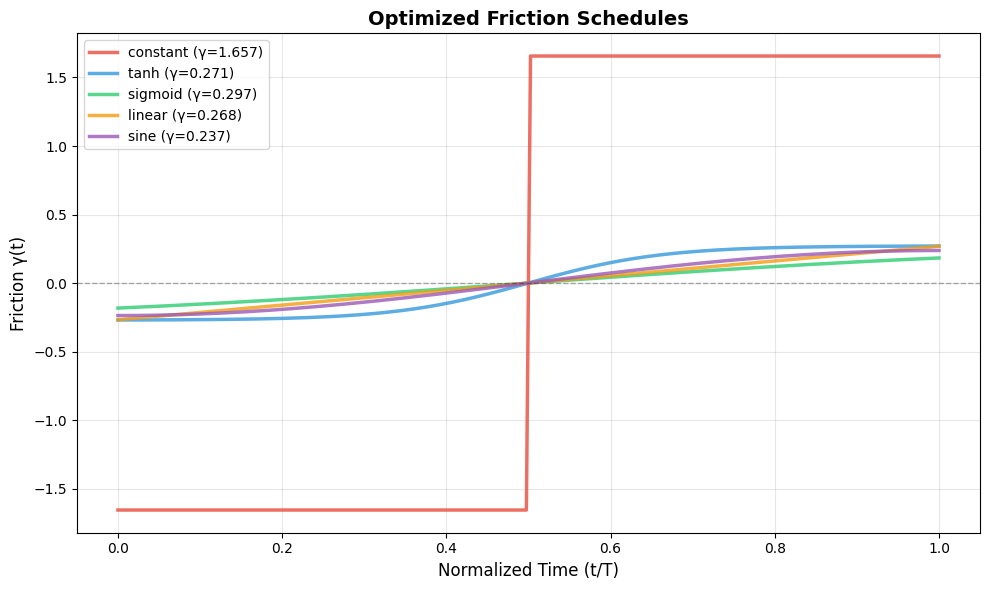


────────────────────────────────────────────────────────────────────────────────
STEP 4: EVALUATING SAMPLING PERFORMANCE
────────────────────────────────────────────────────────────────────────────────

EVALUATING SAMPLING PERFORMANCE

CONSTANT     | ESS:   737.5 | Prop-ESJD:    1.569 | Acc-ESJD:    1.575 | Accept: 0.646 | Time:   0.41s

TANH         | ESS: 17912.5 | Prop-ESJD:   20.971 | Acc-ESJD:   20.987 | Accept: 0.496 | Time:   0.39s

SIGMOID      | ESS: 12027.6 | Prop-ESJD:   90.432 | Acc-ESJD:   90.967 | Accept: 0.414 | Time:   0.39s

LINEAR       | ESS: 11487.0 | Prop-ESJD:   42.722 | Acc-ESJD:   42.720 | Accept: 0.409 | Time:   0.37s

SINE         | ESS:  7820.3 | Prop-ESJD:   15.390 | Acc-ESJD:   15.414 | Accept: 0.551 | Time:   0.37s


────────────────────────────────────────────────────────────────────────────────
STEP 5: PLOTTING SAMPLING COMPARISONS
────────────────────────────────────────────────────────────────────────────────
✓ Saved sampling comparison to 'sampling_c

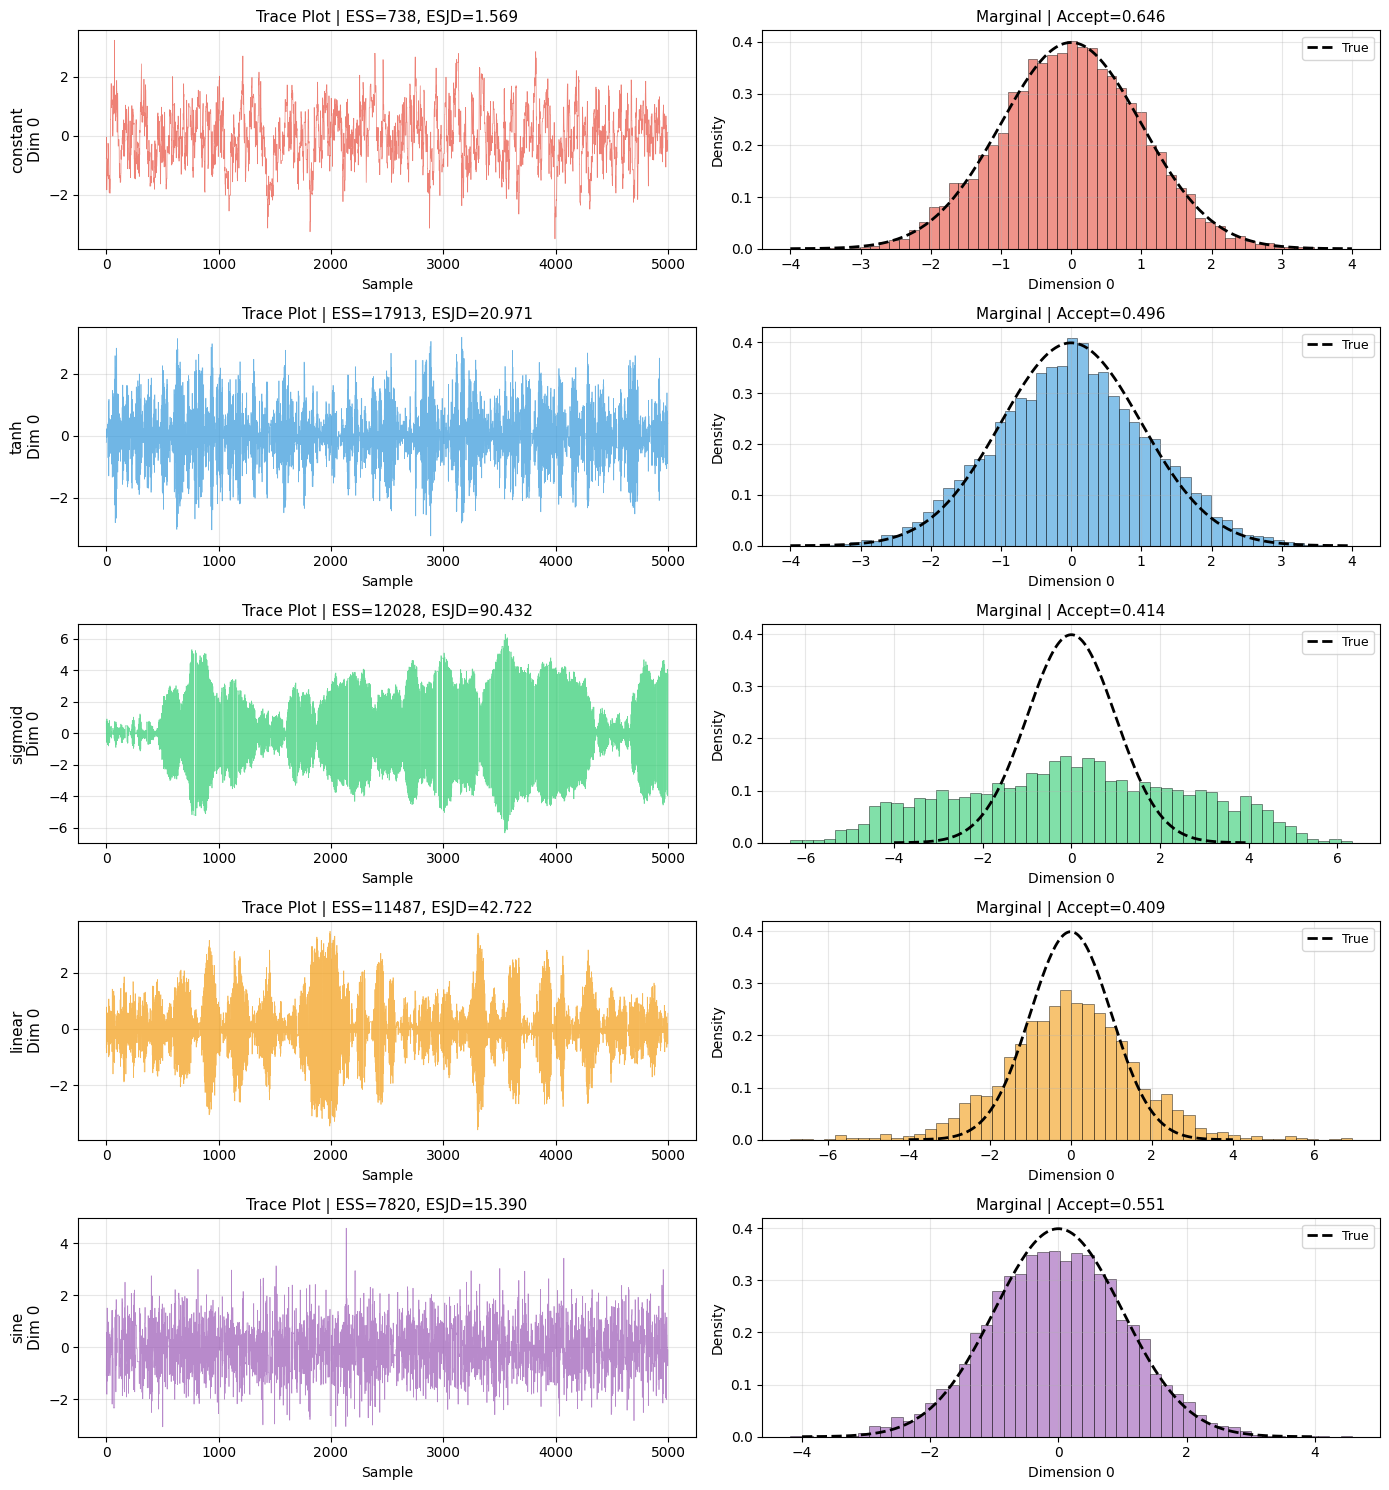

✓ Saved performance summary to 'performance_summary.png'


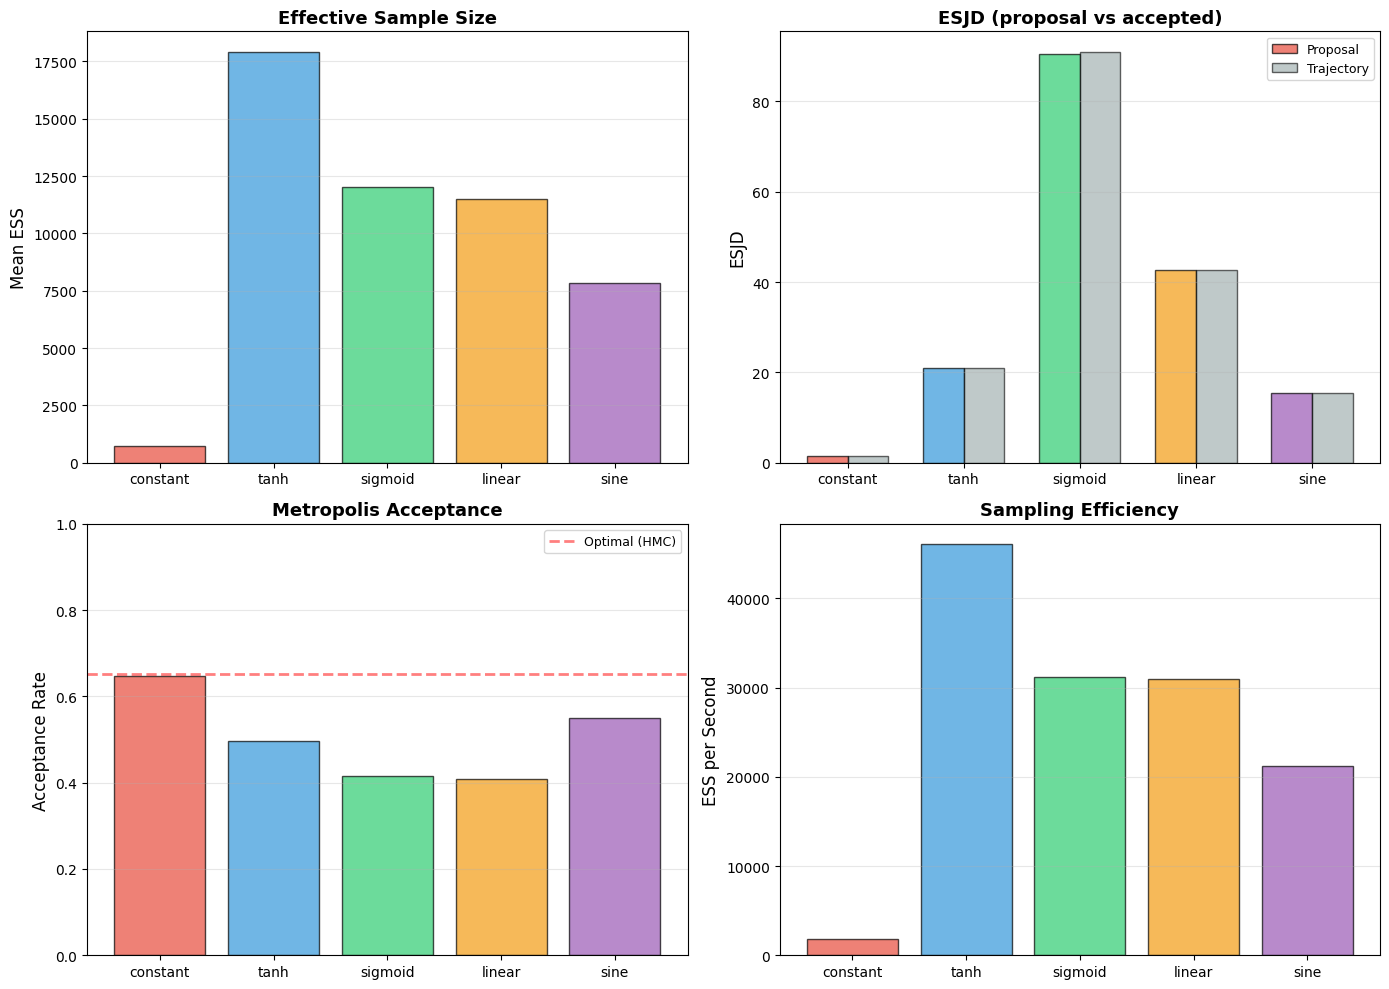


ANALYSIS COMPLETE!

FINAL SUMMARY
Schedule     |      ESS |  Prop-ESJD |  Chain-ESJD |   Accept |        ε |    L |        γ
--------------------------------------------------------------------------------
constant     |    737.5 |     1.5686 |      1.5752 |    0.646 |   0.3332 |   30 |   1.6566
tanh         |  17912.5 |    20.9707 |     20.9871 |    0.496 |   0.1839 |   50 |   0.2711
sigmoid      |  12027.6 |    90.4323 |     90.9669 |    0.414 |   0.1865 |   50 |   0.2967
linear       |  11487.0 |    42.7218 |     42.7202 |    0.409 |   0.1865 |   50 |   0.2683
sine         |   7820.3 |    15.3896 |     15.4143 |    0.551 |   0.2134 |   50 |   0.2374



In [ ]:
import os
os.environ['JAX_LOG_COMPILES'] = '1'

results, performance = run_complete_analysis(
    dim=10,
    n_optimization_steps=300,
    n_eval_samples=5000,
    seed=30,
)

# Print summary table
print("\n" + "="*80)
print("FINAL SUMMARY")
print("="*80)
print(f"{'Schedule':<12} | {'ESS':>8} | {'Prop-ESJD':>10} | {'Chain-ESJD':>11} | {'Accept':>8} | "
        f"{'ε':>8} | {'L':>4} | {'γ':>8}")
print("-"*80)

for schedule_type in results.keys():
    perf = performance[schedule_type]
    params = perf['params']
    prop_esjd = perf.get('proposal_esjd', float('nan'))
    chain_esjd = perf.get('accepted_esjd', float('nan'))
    mean_ess = perf.get('mean_ess', float('nan'))
    accept = perf.get('accept_rate', float('nan'))

    print(f"{schedule_type:<12} | "
          f"{mean_ess:8.1f} | "
          f"{prop_esjd:10.4f} | "
          f"{chain_esjd:11.4f} | "
          f"{accept:8.3f} | "
          f"{params['step_size']:8.4f} | "
          f"{params['num_steps']:4d} | "
          f"{params['gamma']:8.4f}")


print("="*80 + "\n")